In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch
import wandb

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Загружаем данные

In [2]:
with open('data/processed_corpus.json', encoding='utf-8') as f:
    corpus = json.load(f)

In [3]:
print('Corpus length:', len(corpus))
for text in corpus[:5]:
    print(' '.join(text))

Corpus length: 100000
второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [4]:
sample_text = corpus[1]
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

## Реализуйте разделение предложения на примеры методом CBOW

In [5]:
def cbow_split(tokens, window, pad_token='PAD'):
    # дополняем последовательность нужными тегами
    tokens_copy = ['PAD'] * window + tokens + ['PAD'] * window
    seq_len = len(tokens_copy)  - window
    
    # последовательно отдаем срез левого контекста, таргетное слово и срез правого контекста
    for i in range(window, seq_len):
        yield [
            tokens_copy[i-2:i],
            tokens_copy[i],
            tokens_copy[i+1:i+1+window]
        ]
        
# преобразуем в список выход из генератора
splits = list(cbow_split(sample_text, window=2))

In [6]:
for sample in splits[:3]:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вернуть
Правый контекст: ['денежный', 'средство']

Левый контекст: ['PAD', 'вернуть']
Центральное слово: денежный
Правый контекст: ['средство', 'лицевой']

Левый контекст: ['вернуть', 'денежный']
Центральное слово: средство
Правый контекст: ['лицевой', 'счёт']



In [7]:
splits

[[['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']],
 [['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']],
 [['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']],
 [['денежный', 'средство'], 'лицевой', ['счёт', 'либо']],
 [['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']],
 [['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']],
 [['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']],
 [['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']],
 [['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']],
 [['счёт', 'погашение'], 'кредит', ['PAD', 'PAD']]]

## Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [8]:
list(cbow_split(sample_text, window=3))

[[['PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']],
 [['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']],
 [['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']],
 [['денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']],
 [['средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']],
 [['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']],
 [['счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']],
 [['либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']],
 [['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']],
 [['счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD']]]

## Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

## Реализуйте разделение предложения на примеры методом Skipgram

In [9]:
def skipgram_split(tokens, window):
    
    for i, target_tok in enumerate(tokens):
        
        for context in tokens[max(i-window, 0):i+1+window]:
            if context != target_tok:
                yield [context, target_tok]
                
splits = list(skipgram_split(sample_text, window=2))

In [10]:
for sample in splits[:3]:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: денежный
Центральное слово: вернуть

Контекст: средство
Центральное слово: вернуть

Контекст: вернуть
Центральное слово: денежный



In [11]:
list(skipgram_split(sample_text, window=2))

[['денежный', 'вернуть'],
 ['средство', 'вернуть'],
 ['вернуть', 'денежный'],
 ['средство', 'денежный'],
 ['лицевой', 'денежный'],
 ['вернуть', 'средство'],
 ['денежный', 'средство'],
 ['лицевой', 'средство'],
 ['счёт', 'средство'],
 ['денежный', 'лицевой'],
 ['средство', 'лицевой'],
 ['счёт', 'лицевой'],
 ['либо', 'лицевой'],
 ['средство', 'счёт'],
 ['лицевой', 'счёт'],
 ['либо', 'счёт'],
 ['зачесть', 'счёт'],
 ['лицевой', 'либо'],
 ['счёт', 'либо'],
 ['зачесть', 'либо'],
 ['счёт', 'либо'],
 ['счёт', 'зачесть'],
 ['либо', 'зачесть'],
 ['счёт', 'зачесть'],
 ['погашение', 'зачесть'],
 ['либо', 'счёт'],
 ['зачесть', 'счёт'],
 ['погашение', 'счёт'],
 ['кредит', 'счёт'],
 ['зачесть', 'погашение'],
 ['счёт', 'погашение'],
 ['кредит', 'погашение'],
 ['счёт', 'кредит'],
 ['погашение', 'кредит']]

## Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [12]:
list(skipgram_split(sample_text, window=3))

[['денежный', 'вернуть'],
 ['средство', 'вернуть'],
 ['лицевой', 'вернуть'],
 ['вернуть', 'денежный'],
 ['средство', 'денежный'],
 ['лицевой', 'денежный'],
 ['счёт', 'денежный'],
 ['вернуть', 'средство'],
 ['денежный', 'средство'],
 ['лицевой', 'средство'],
 ['счёт', 'средство'],
 ['либо', 'средство'],
 ['вернуть', 'лицевой'],
 ['денежный', 'лицевой'],
 ['средство', 'лицевой'],
 ['счёт', 'лицевой'],
 ['либо', 'лицевой'],
 ['зачесть', 'лицевой'],
 ['денежный', 'счёт'],
 ['средство', 'счёт'],
 ['лицевой', 'счёт'],
 ['либо', 'счёт'],
 ['зачесть', 'счёт'],
 ['средство', 'либо'],
 ['лицевой', 'либо'],
 ['счёт', 'либо'],
 ['зачесть', 'либо'],
 ['счёт', 'либо'],
 ['погашение', 'либо'],
 ['лицевой', 'зачесть'],
 ['счёт', 'зачесть'],
 ['либо', 'зачесть'],
 ['счёт', 'зачесть'],
 ['погашение', 'зачесть'],
 ['кредит', 'зачесть'],
 ['либо', 'счёт'],
 ['зачесть', 'счёт'],
 ['погашение', 'счёт'],
 ['кредит', 'счёт'],
 ['либо', 'погашение'],
 ['зачесть', 'погашение'],
 ['счёт', 'погашение'],
 ['кредит

In [3]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)
            
            
print('Vocabulary length:', len(word2index), '\nIndex of UNK token', word2index['UNK'])

Vocabulary length: 13076 
Index of UNK token 1


In [14]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [15]:
from torch.utils.data import Dataset, DataLoader

In [16]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [17]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.35453404, 0.15025155, 0.90116211, 0.0971911 ],
       [0.54280478, 0.75906449, 0.58294513, 0.12389473],
       [0.24163189, 0.50317963, 0.20846688, 0.50745017],
       [0.53226397, 0.06381856, 0.30855885, 0.0452815 ],
       [0.34309547, 0.56140863, 0.64313644, 0.1386887 ],
       [0.34663635, 0.29325772, 0.50375566, 0.03505337],
       [0.3180392 , 0.44125958, 0.11922348, 0.28499495],
       [0.55452569, 0.83346591, 0.538324  , 0.31018276],
       [0.88105536, 0.93738832, 0.75736945, 0.18321601],
       [0.6850886 , 0.45060405, 0.25043265, 0.70841084]])

In [18]:
some_data_y

array([1, 1, 0, ..., 0, 1, 0])

In [19]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [20]:
some_dataset = ToyDataset(some_data_x, some_data_y)
some_dataset[5], some_dataset[467]

((array([0.34663635, 0.29325772, 0.50375566, 0.03505337]), 1),
 (array([0.18585658, 0.67022462, 0.04040156, 0.08156871]), 0))

In [21]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

x, y = next(iter(some_loader))
    
len(x), x

(16,
 tensor([[0.9426, 0.5520, 0.3379, 0.4192],
         [0.7305, 0.5630, 0.9489, 0.8690],
         [0.7187, 0.0495, 0.1853, 0.3804],
         [0.2200, 0.5509, 0.4869, 0.1931],
         [0.2708, 0.7748, 0.3939, 0.9479],
         [0.6961, 0.6754, 0.7553, 0.9639],
         [0.8623, 0.3670, 0.3847, 0.6589],
         [0.4683, 0.4587, 0.4763, 0.6544],
         [0.3711, 0.0091, 0.1801, 0.9176],
         [0.7969, 0.8395, 0.8634, 0.8001],
         [0.1896, 0.7298, 0.0759, 0.1345],
         [0.8974, 0.7080, 0.1317, 0.0119],
         [0.5329, 0.6269, 0.4267, 0.1274],
         [0.5095, 0.0413, 0.5966, 0.6259],
         [0.7182, 0.7639, 0.4619, 0.3035],
         [0.1309, 0.9550, 0.4814, 0.1491]], dtype=torch.float64))

In [22]:
x, y = next(iter(some_loader))

len(x)

16

# А зачем?

In [23]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [24]:
toy_dataset = ToyDataset(some_data_x, some_data_y)
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [25]:
x, y = next(iter(toy_loader))
x.shape

torch.Size([128, 32])

In [26]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 3.5453e-01,  1.5025e-01,  9.0116e-01,  ..., -1.1373e+01,
         -6.2442e-01, -1.3986e+01],
        [ 5.4280e-01,  7.5906e-01,  5.8295e-01,  ..., -1.6540e+00,
         -3.2380e+00, -1.2530e+01],
        [ 2.4163e-01,  5.0318e-01,  2.0847e-01,  ..., -4.1208e+00,
         -9.4079e+00, -4.0701e+00],
        ...,
        [ 5.2638e-01,  8.2904e-01,  4.3808e-01,  ..., -1.1249e+00,
         -4.9521e+00, -8.9222e-01],
        [ 6.7461e-01,  8.7850e-01,  1.0019e-03,  ..., -7.7726e-01,
         -4.1435e+01, -2.3349e-01],
        [ 6.2693e-02,  1.5456e-01,  8.7761e-01,  ..., -1.1203e+01,
         -7.8332e-01, -9.2877e+00]], dtype=torch.float64)

In [27]:
y

tensor([1, 1, 0, 1, 1, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 2, 2, 2,
        2, 0, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2,
        2, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 2, 0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 0, 0, 0, 1, 2, 2, 1, 2, 1,
        0, 0, 0, 0, 0, 2, 2, 0])

In [28]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [29]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y.long())
    
loss.item()

1.1457834243774414

# Боевые датасеты

## Мы будем учить модель Skipgram - Реализуйте читалку данных и модель

In [30]:
from word2vec_utils import SkipgramDataset, SkipGram

In [31]:
dataset = SkipgramDataset(corpus, word2index)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 30426.07it/s]


In [32]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=5)

In [33]:
x, y = next(iter(dataset_loader)) 

In [34]:
x, x.shape, y, y.shape

(tensor([ 1744,   160,    88, 11839,    70]),
 torch.Size([5]),
 tensor([ 112,   25,   95, 2940, 1011]),
 torch.Size([5]))

In [35]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=20)

In [36]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([5, 13076])

# Допишите обучалку

**Написала по шаблону, который на работе обычно использую**

In [37]:
config = {"method": "grid",
    "parameters": {
    "epochs": {
        "value": 10
    },
    "batch_size": {
        "value": 1024
    },
    "lr": {
        "values": [1e-3, 3e-4, 1e-5]
    },        
    "embedding_dim": {
        "values": [20, 100, 300]
    },
    "seed": {
        "value": 42
    }}}

In [38]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    
    model.train()
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({"batch train loss": loss.item()})
    
    return train_loss / len(dataloader)

In [39]:
from torch.nn import DataParallel

def sweep_training(config=None):
    global corpus, word2index
    
    with wandb.init(config=config) as run:
        config = wandb.config
        torch.manual_seed(config.seed)
        random.seed(config.seed)
        np.random.seed(config.seed)
        
        model_name = f'skipgram_vec_dim{config.embedding_dim}_lr{config.lr}'
        run.name = model_name
        
        dataset = SkipgramDataset(corpus, word2index, collect_verbose=False)
        train_dataloader = DataLoader(dataset, shuffle=True, batch_size=config.batch_size)        

        model = SkipGram(vocab_size=len(word2index), embedding_dim=config.embedding_dim)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.lr)
        criterion = torch.nn.CrossEntropyLoss()
        
        device = 'cuda'
        model = DataParallel(model).to(device)
        
        for n_epoch in range(config.epochs):
            avg_train_loss = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=criterion,
                                        optimizer=optimizer,
                                        device=device)
            wandb.log({"train loss": avg_train_loss,
                       "epoch": n_epoch})
            
        torch.save(model.module.in_embedding.state_dict()['weight'],
                   model_name + '.pt')

In [ ]:
sweep_id = wandb.sweep(config, project="skipgram-on-bank-corpus")
wandb.agent(sweep_id, sweep_training)

[Ссылка на логгинг](https://wandb.ai/annette-mikhaylova/skipgram-on-bank-corpus/reports/HW1-logging--Vmlldzo1NzM3Mjgy)

<div>
<img src="logs.png" width="700"/>
</div>

**Вывод:** лучше всего учится с lr 0.001 и векторами размера 300. К сожалению, качество полученных векторов несмотря на низкий лосс. Видимо, модель подстроилась под специфичный корпус. Поэтому далее используем вектора размера 20

In [4]:
embedding_matrix = torch.load('skipgram_vec_dim20_lr0.001.pt')
embedding_matrix = embedding_matrix.detach().cpu()

In [43]:
def cos_sim(embedding_matrix, token2id, word1, word2):
        
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [44]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.6123911738395691

In [45]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.4344053864479065

In [46]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.7874667644500732

In [47]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.5129177570343018

In [48]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "майла" равна -0.098'

In [5]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.001s...
[t-SNE] Computed neighbors for 13076 samples in 0.835s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [8]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1
            
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]
top_words = [a for a,_ in top_sorted_freq]
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

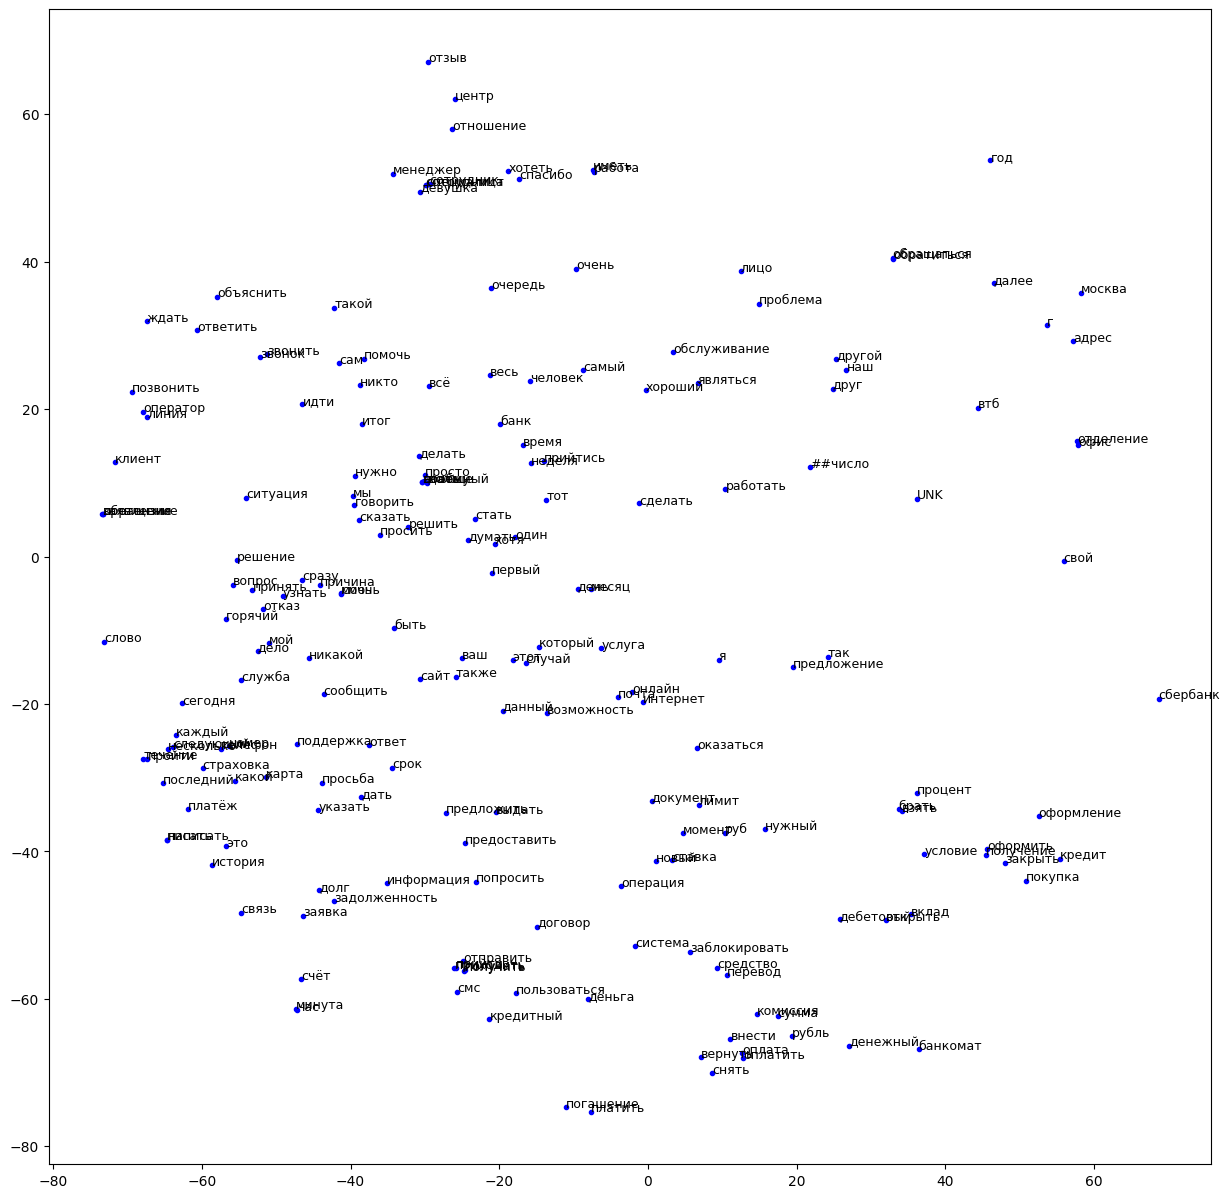

In [9]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Сравнивая результаты человеческой разметки и наши вектора

In [53]:
# подгружаем размеченные данные
import pandas as pd

ru_simlex965 = pd.read_csv('data/ru_simlex965_tagged.tsv', sep='\t')

In [54]:
# чистим данные (частеречные теги не используем, потому что в данных их нет)
ru_simlex965.rename(columns={'# Word1': 'Word1'}, inplace=True)
s_strip = lambda x: x.split('_')[0]
ru_simlex965.Word1 = ru_simlex965.Word1.apply(s_strip)
ru_simlex965.Word2 = ru_simlex965.Word2.apply(s_strip)

In [55]:
# считаем cosine_similarities для тех слов, которые есть в нашем словаре
cosine_similarities = [cos_sim(embedding_matrix, word2index, w1, w2) if w1 in word2index and w2 in word2index else np.nan
                       for w1, w2 in zip(ru_simlex965.Word1, ru_simlex965.Word2)]
ru_simlex965['CosineSimilarities'] = cosine_similarities

In [56]:
# посмотрим, скольких слов нет в нашем корпусе
all_words = pd.concat([ru_simlex965.Word1, ru_simlex965.Word2]).unique()
not_in_word2index = sum([w in word2index for w in all_words])
not_in_word2index, not_in_word2index / len(all_words)

(677, 0.6404919583727531)

In [57]:
# посчитаем корреляцию Спирмана для наших выходных данных и чистых данных
# как было описано в статье
ru_simlex965.dropna()[['Average Score', 'CosineSimilarities']].corr(method='spearman')

,Average Score,CosineSimilarities
Average Score,1.000000,0.093401
CosineSimilarities,0.093401,1.000000


In [58]:
# также посчитаем mse для получившихся результатов
# прежде отнормировав Average Score 
from sklearn.metrics import mean_squared_error as mse

ru_simlex965['NormalizedScore'] = ru_simlex965['Average Score'] / ru_simlex965['Average Score'].max()
mse(y_true=ru_simlex965.dropna()['NormalizedScore'],
    y_pred=ru_simlex965.dropna()['CosineSimilarities'])

0.13474695407371243

Возможно имеет смысл сделать лучшую предобработку 

    1. поправив опечатки,
    2. лемматизируя в Mystem с дизамбигуацией и частеречной разметкой,
    3. возможно, разбавить корпус другими типами текстов
    
Но это немного долго

    К О Н Е Ц